In [1]:
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    accuracy_score
)
from sklearn.preprocessing import label_binarize

import os, random
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import (
    convnext_tiny, ConvNeXt_Tiny_Weights,
    efficientnet_b0, EfficientNet_B0_Weights
)
import timm

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [7]:
# Paths
data_dir = r"C:/Users/ZA SEYAM/AgroSpectraNet/data/processed"

# Paths
train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "validation")
test_dir  = os.path.join(data_dir, "test")

# Transforms (example, can be tuned)
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets
train_ds = ImageFolder(train_dir, transform=transform_train)
val_ds   = ImageFolder(val_dir, transform=transform_eval)
test_ds  = ImageFolder(test_dir, transform=transform_eval)

# Classes
NUM_CLASSES = len(train_ds.classes)
print("Classes:", NUM_CLASSES, train_ds.classes[:5], "...")  # show sample

# Loaders
train_loader = DataLoader(
    train_ds,
    batch_size=16,
    shuffle=True,
    num_workers=2,      
    pin_memory=False,
    persistent_workers=False
)

val_loader = DataLoader(
    val_ds,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=False,
    persistent_workers=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=False,
    persistent_workers=False
)

Classes: 30 ['corn_cercospora_leaf_spot', 'corn_common_rust', 'corn_healthy', 'corn_northern_leaf_blight', 'jute_cescospora_leaf_spot'] ...


In [8]:
class EfficientNetB0_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # EfficientNet-B0
        self.effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        # Replace classifier with new layer for our classes
        self.effnet.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.effnet(x)

# Initialize
model = EfficientNetB0_Model(NUM_CLASSES).to(device)
print(model)

EfficientNetB0_Model(
  (effnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)
scaler = GradScaler()   # ✅ AMP scaler

# --- Training function ---
def train_one_epoch(model, loader, optimizer, criterion, scaler, device):
    model.train()
    running_loss, correct, total = 0, 0, 0
    pbar = tqdm(loader, desc="Training", leave=False)

    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        # ✅ autocast for mixed precision
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(loss=loss.item(), acc=correct/total)

    return running_loss / total, correct / total

# --- Evaluation function ---
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_24092\1839667932.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()   # ✅ AMP scaler


In [10]:
EPOCHS = 30 
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_acc = 0.0

for epoch in range(1, EPOCHS+1):
    print(f"\n===== Epoch {epoch}/{EPOCHS} =====")
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "C:/Users/ZA SEYAM/AgroSpectraNet/models/trained/EfficientNet-B0.pt")
        print("💾 Saved Best Model")


===== Epoch 1/30 =====


Training:   0%|          | 0/807 [00:07<?, ?it/s]

C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_24092\1839667932.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_24092\1839667932.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.7283 | Train Acc: 0.7709
Val   Loss: 0.2476 | Val   Acc: 0.9158
💾 Saved Best Model

===== Epoch 2/30 =====


Training:   0%|          | 0/807 [00:07<?, ?it/s]

Train Loss: 0.3000 | Train Acc: 0.8982
Val   Loss: 0.1864 | Val   Acc: 0.9360
💾 Saved Best Model

===== Epoch 3/30 =====


Training:   0%|          | 0/807 [00:07<?, ?it/s]

Train Loss: 0.2311 | Train Acc: 0.9203
Val   Loss: 0.1857 | Val   Acc: 0.9346

===== Epoch 4/30 =====


Training:   0%|          | 0/807 [00:07<?, ?it/s]

Train Loss: 0.1829 | Train Acc: 0.9392
Val   Loss: 0.2181 | Val   Acc: 0.9349

===== Epoch 5/30 =====


Training:   0%|          | 0/807 [00:07<?, ?it/s]

Train Loss: 0.1578 | Train Acc: 0.9482
Val   Loss: 0.1975 | Val   Acc: 0.9393
💾 Saved Best Model

===== Epoch 6/30 =====


Training:   0%|          | 0/807 [00:07<?, ?it/s]

Train Loss: 0.1416 | Train Acc: 0.9537
Val   Loss: 0.1580 | Val   Acc: 0.9534
💾 Saved Best Model

===== Epoch 7/30 =====


Training:   0%|          | 0/807 [00:07<?, ?it/s]

Train Loss: 0.1327 | Train Acc: 0.9566
Val   Loss: 0.2058 | Val   Acc: 0.9498

===== Epoch 8/30 =====


Training:   0%|          | 0/807 [00:08<?, ?it/s]

Train Loss: 0.1113 | Train Acc: 0.9620
Val   Loss: 0.1610 | Val   Acc: 0.9530

===== Epoch 9/30 =====


Training:   0%|          | 0/807 [00:08<?, ?it/s]

Train Loss: 0.1201 | Train Acc: 0.9604
Val   Loss: 0.1728 | Val   Acc: 0.9458

===== Epoch 10/30 =====


Training:   0%|          | 0/807 [00:07<?, ?it/s]

Train Loss: 0.1017 | Train Acc: 0.9663
Val   Loss: 0.1704 | Val   Acc: 0.9545
💾 Saved Best Model

===== Epoch 11/30 =====


Training:   0%|          | 0/807 [00:08<?, ?it/s]

Train Loss: 0.0522 | Train Acc: 0.9830
Val   Loss: 0.1669 | Val   Acc: 0.9584
💾 Saved Best Model

===== Epoch 12/30 =====


Training:   0%|          | 0/807 [00:08<?, ?it/s]

Train Loss: 0.0404 | Train Acc: 0.9866
Val   Loss: 0.1910 | Val   Acc: 0.9537

===== Epoch 13/30 =====


Training:   0%|          | 0/807 [00:08<?, ?it/s]

Train Loss: 0.0380 | Train Acc: 0.9871
Val   Loss: 0.1834 | Val   Acc: 0.9588
💾 Saved Best Model

===== Epoch 14/30 =====


Training:   0%|          | 0/807 [00:08<?, ?it/s]

Train Loss: 0.0404 | Train Acc: 0.9873
Val   Loss: 0.1944 | Val   Acc: 0.9555

===== Epoch 15/30 =====


Training:   0%|          | 0/807 [00:08<?, ?it/s]

Train Loss: 0.0216 | Train Acc: 0.9932
Val   Loss: 0.1750 | Val   Acc: 0.9624
💾 Saved Best Model

===== Epoch 16/30 =====


Training:   0%|          | 0/807 [00:09<?, ?it/s]

Train Loss: 0.0180 | Train Acc: 0.9942
Val   Loss: 0.1881 | Val   Acc: 0.9628
💾 Saved Best Model

===== Epoch 17/30 =====


Training:   0%|          | 0/807 [00:08<?, ?it/s]

Train Loss: 0.0152 | Train Acc: 0.9954
Val   Loss: 0.2040 | Val   Acc: 0.9602

===== Epoch 18/30 =====


Training:   0%|          | 0/807 [00:08<?, ?it/s]

Train Loss: 0.0143 | Train Acc: 0.9951
Val   Loss: 0.1971 | Val   Acc: 0.9624

===== Epoch 19/30 =====


Training:   0%|          | 0/807 [00:07<?, ?it/s]

Train Loss: 0.0111 | Train Acc: 0.9967
Val   Loss: 0.1816 | Val   Acc: 0.9635
💾 Saved Best Model

===== Epoch 20/30 =====


Training:   0%|          | 0/807 [00:08<?, ?it/s]

Train Loss: 0.0104 | Train Acc: 0.9970
Val   Loss: 0.1822 | Val   Acc: 0.9653
💾 Saved Best Model

===== Epoch 21/30 =====


Training:   0%|          | 0/807 [00:09<?, ?it/s]

Train Loss: 0.0056 | Train Acc: 0.9988
Val   Loss: 0.2033 | Val   Acc: 0.9639

===== Epoch 22/30 =====


Training:   0%|          | 0/807 [00:09<?, ?it/s]

Train Loss: 0.0075 | Train Acc: 0.9974
Val   Loss: 0.2053 | Val   Acc: 0.9631

===== Epoch 23/30 =====


Training:   0%|          | 0/807 [00:08<?, ?it/s]

Train Loss: 0.0081 | Train Acc: 0.9978
Val   Loss: 0.2037 | Val   Acc: 0.9649

===== Epoch 24/30 =====


Training:   0%|          | 0/807 [00:07<?, ?it/s]

Train Loss: 0.0055 | Train Acc: 0.9983
Val   Loss: 0.2009 | Val   Acc: 0.9646

===== Epoch 25/30 =====


Training:   0%|          | 0/807 [00:07<?, ?it/s]

Train Loss: 0.0076 | Train Acc: 0.9970
Val   Loss: 0.1986 | Val   Acc: 0.9649

===== Epoch 26/30 =====


Training:   0%|          | 0/807 [00:07<?, ?it/s]

Train Loss: 0.0046 | Train Acc: 0.9988
Val   Loss: 0.1966 | Val   Acc: 0.9675
💾 Saved Best Model

===== Epoch 27/30 =====


Training:   0%|          | 0/807 [00:07<?, ?it/s]

Train Loss: 0.0039 | Train Acc: 0.9987
Val   Loss: 0.2023 | Val   Acc: 0.9664

===== Epoch 28/30 =====


Training:   0%|          | 0/807 [00:08<?, ?it/s]

Train Loss: 0.0052 | Train Acc: 0.9984
Val   Loss: 0.1939 | Val   Acc: 0.9657

===== Epoch 29/30 =====


Training:   0%|          | 0/807 [00:08<?, ?it/s]

Train Loss: 0.0054 | Train Acc: 0.9988
Val   Loss: 0.1979 | Val   Acc: 0.9660

===== Epoch 30/30 =====


Training:   0%|          | 0/807 [00:07<?, ?it/s]

Train Loss: 0.0052 | Train Acc: 0.9982
Val   Loss: 0.2006 | Val   Acc: 0.9660


✅ Training curves saved at: C:/Users/ZA SEYAM/AgroSpectraNet/results/efficientNet_training_curves.png


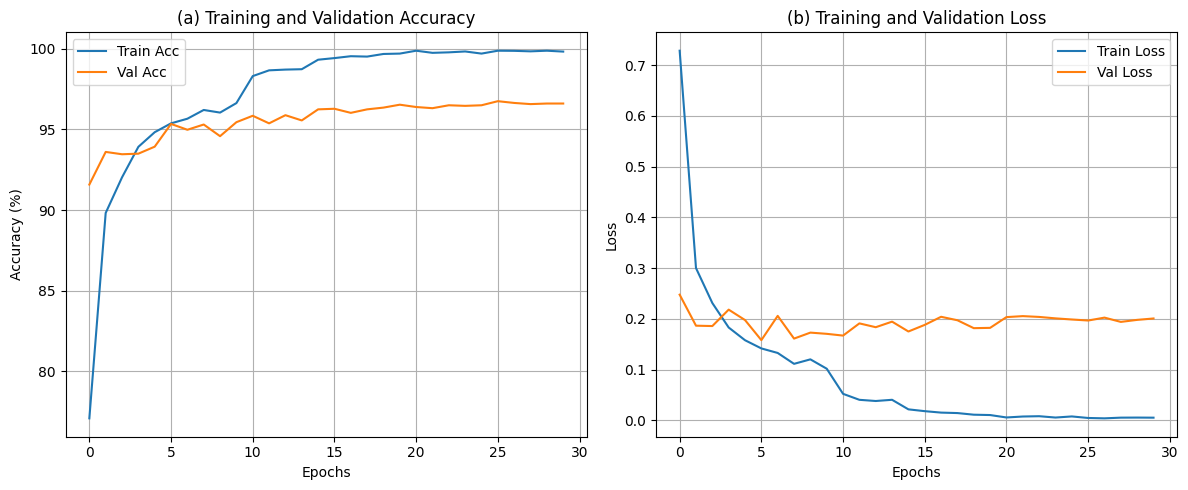

In [11]:
# Plot Training & Validation Curves (Accuracy in %)
def plot_curves(history, save_path="training_curves.png"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # (a) Accuracy subplot (converted to percentage)
    axes[0].plot([acc * 100 for acc in history["train_acc"]], label="Train Acc")
    axes[0].plot([acc * 100 for acc in history["val_acc"]], label="Val Acc")
    axes[0].set_title("(a) Training and Validation Accuracy", fontsize=12)
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].legend()
    axes[0].grid(True)

    # (b) Loss subplot (keeps original scale)
    axes[1].plot(history["train_loss"], label="Train Loss")
    axes[1].plot(history["val_loss"], label="Val Loss")
    axes[1].set_title("(b) Training and Validation Loss", fontsize=12)
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout
    plt.tight_layout()

    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"✅ Training curves saved at: {save_path}")

    # Show figure
    plt.show()


# Example usage
plot_curves(history, save_path="C:/Users/ZA SEYAM/AgroSpectraNet/results/efficientNet_training_curves.png")

In [14]:
# Load best model
model.load_state_dict(torch.load("C:/Users/ZA SEYAM/AgroSpectraNet/models/trained/EfficientNet-B0.pt"))

# Final evaluation
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc:.4f}")

C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_24092\1839667932.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Final Test Loss: 0.2374 | Final Test Acc: 0.9604
